# Text Emotion Recognition using BiLSTM Layers in Neural Network

In [47]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Layer
import re
import contractions
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

## Loading pre-trained Word2Vec model

In [45]:
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) ##preloaded word2vec model for conversion

In [46]:
num_emotions = 6 ## anger, joy, sadness , fear, love, surprise
TEST_SIZE = 0.01
EPOCHS = 20
nltk.download('stopwords')
nltk.download("wordnet")
stopwords_default = stopwords.words('english')
stopwords_default = [word for word in stopwords_default if word not in ['not', 'never', 'no', 'none', 'but', 'however', 'although', 'very']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thejus03/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thejus03/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading, Cleaning and Processing of data from database

In [38]:
def load_data(filename):
    
    with open(filename) as f:
        
        ## Using Panda to read the csv file
        df = pd.read_csv(filename, sep=';', on_bad_lines='skip')
        
        print("Loading data...")
        print()
        
        ##Loading the data
        labels = [row["sentiment"] for index, row in df.iterrows()]
        evidence = [row["content"] for index,row in df.iterrows()]

        ## Cleaning the data using various libraries
        evidence1=[]
        for sentence in evidence:
            sentence = sentence.lower()
            sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
            sentence = re.sub(r'<.*?>', '', sentence)
            sentence = contractions.fix(sentence)
            sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
            sentence = re.sub(r'\s+', ' ', sentence).strip()
            evidence1.append(sentence)
        evidence=evidence1
        
        ## Tokenizing the sentences
        evidence = [word_tokenize(sentence.lower()) for sentence in evidence]
        ## Removing the stopwords
        evidence = [[word for word in sentence if word not in stopwords_default] for sentence in evidence]
        ## Lemmatizing the words for word2vec to process
        lemmatizer = WordNetLemmatizer()
        evidence = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in evidence]
        ## Converting the words to the indexes in word2vec for the embedding layer 
        evidence = [[word2vec_model.key_to_index[word] for word in sentence if word in word2vec_model.key_to_index] for sentence in evidence]
        ## Padding the sentences to a fixed length for feeding as input for the model 
        evidence = tf.keras.preprocessing.sequence.pad_sequences(evidence,padding='post')
        
        
        return evidence,labels

## Model Structure

In [41]:
def get_model(evidence,labels, embedding_matrix):
    
    model = tf.keras.models.Sequential([
        ## Embedding layer using word2vec
        tf.keras.layers.Embedding(input_dim=len(word2vec_model.key_to_index) + 1, output_dim=word2vec_model.vector_size, weights=[embedding_matrix],input_length=max_length, trainable=False),
        
        ## LSTM layer
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
        ## Dropout layer
         tf.keras.layers.Dropout(0.5),
        
        ## LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
        ## Dropout layer
        tf.keras.layers.Dropout(0.5),
        
        ## LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
        ## Dropout layer
        tf.keras.layers.Dropout(0.5),
        
        ## Max-Pooling and flattening for the output layer
        tf.keras.layers.GlobalMaxPooling1D(),
        
        ## Final Output layer
        tf.keras.layers.Dense(num_emotions, activation="softmax")
        
        
    ])
    
    ## Compile model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    records=model.fit(evidence, labels, epochs=EPOCHS, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    return model,records

## Manipulating training and test data for the model's usage

In [49]:
evidence, labels = load_data("emotion.csv")
max_length = len(evidence[0])

## To give each label a unique numerical value
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

## To one-hot-encode each numerical representation of the labels
labels = tf.keras.utils.to_categorical(integer_labels) 

## Splitting test and train data
evidence_train,evidence_test,labels_train, labels_test = train_test_split(
    evidence, labels, test_size=TEST_SIZE, shuffle=True, stratify=labels
)
## For the embedding layer's reference to convert evidence data to its word2vec vector representation
embedding_matrix = np.zeros((len(word2vec_model.key_to_index) + 1, word2vec_model.vector_size))
for word, i in word2vec_model.key_to_index.items():
    embedding_vector = word2vec_model[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loading data...



## Training the model

In [20]:
model, records = get_model(evidence_train, labels_train, embedding_matrix)

Epoch 1/20
740/740 [==============================] - 53s 69ms/step - loss: 0.7320 - accuracy: 0.7306 - val_loss: 0.5089 - val_accuracy: 0.8390
Epoch 2/20
740/740 [==============================] - 47s 63ms/step - loss: 0.4153 - accuracy: 0.8455 - val_loss: 0.4289 - val_accuracy: 0.8595
Epoch 3/20
740/740 [==============================] - 51s 69ms/step - loss: 0.3513 - accuracy: 0.8657 - val_loss: 0.4145 - val_accuracy: 0.8623
Epoch 4/20
740/740 [==============================] - 46s 62ms/step - loss: 0.3159 - accuracy: 0.8750 - val_loss: 0.3903 - val_accuracy: 0.8537
Epoch 5/20
740/740 [==============================] - 46s 62ms/step - loss: 0.3001 - accuracy: 0.8827 - val_loss: 0.4159 - val_accuracy: 0.8595
Epoch 6/20
740/740 [==============================] - 46s 62ms/step - loss: 0.2755 - accuracy: 0.8889 - val_loss: 0.4012 - val_accuracy: 0.8581
Epoch 7/20
740/740 [==============================] - 46s 62ms/step - loss: 0.2511 - accuracy: 0.9000 - val_loss: 0.3840 - val_accuracy:

## Model Summary

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 300)           900000300 
                                                                 
 bidirectional_12 (Bidirect  (None, 34, 200)           320800    
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 34, 200)           0         
                                                                 
 bidirectional_13 (Bidirect  (None, 34, 400)           641600    
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 34, 400)           0         
                                                                 
 bidirectional_14 (Bidirect  (None, 34, 200)          

## Evaluation of the model

In [21]:
model.evaluate(evidence_test, labels_test, verbose=2)

10/10 - 1s - loss: 0.3175 - accuracy: 0.8829 - 693ms/epoch - 69ms/step


[0.31745287775993347, 0.8829431533813477]

### Accuracy of the model on test data is 88.3%

## Training Loss vs Validation Loss

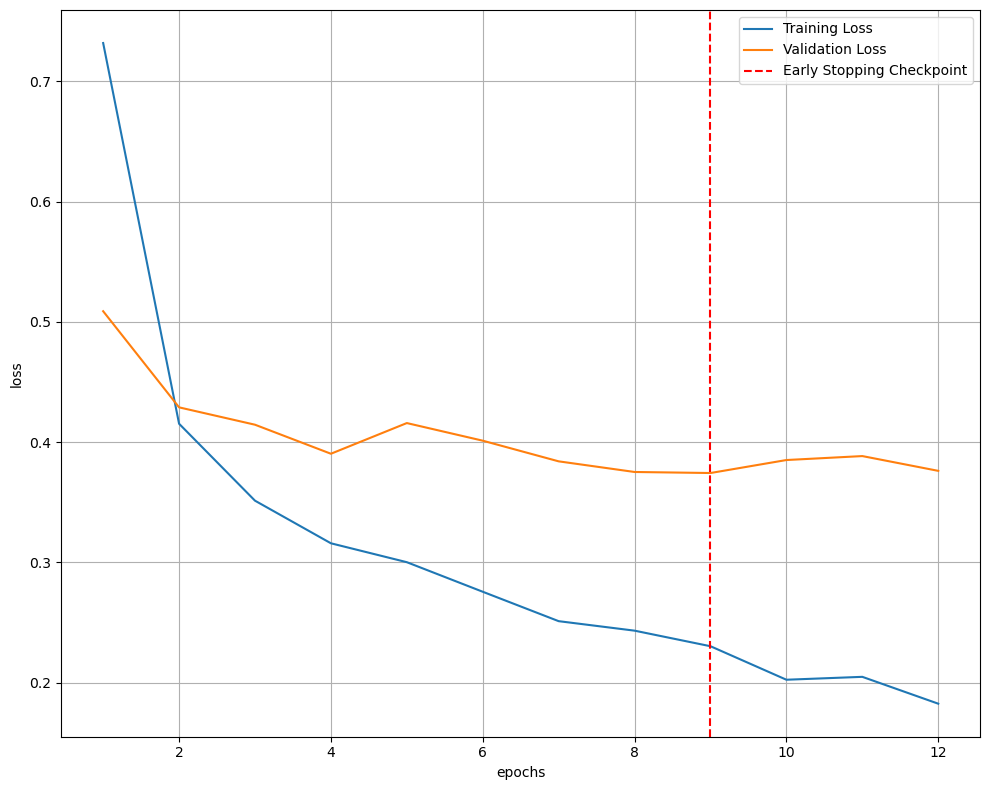

In [34]:
tr_loss=records.history['loss']
te_loss= records.history['val_loss']
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(tr_loss) + 1), tr_loss, label='Training Loss')
plt.plot(range(1, len(te_loss) + 1), te_loss, label='Validation Loss')
minposs = te_loss.index(min(te_loss)) + 1 
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Training Accuracy vs Validation Accuracy

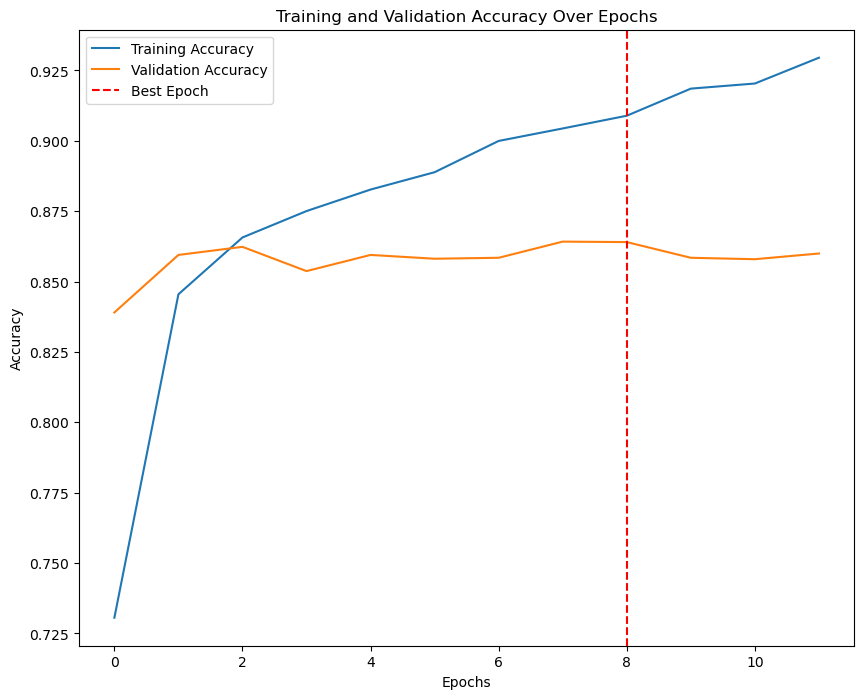

In [35]:
tr_accuracy = records.history['accuracy']
val_accuracy = records.history['val_accuracy']
plt.figure(figsize=(10, 8))
plt.plot(tr_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
max_acc_epoch = val_accuracy.index(max(val_accuracy)) + 1
plt.axvline(max_acc_epoch, linestyle='--', color='r', label='Best Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()